In [35]:
# Doing all the imports

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress
import pandas as pd
import numpy as np
import os

In [36]:
def create_folder(folder_name):
    # Check if the folder already exists
    if not os.path.exists(folder_name):
        # Create the folder if it doesn't exist
        os.makedirs(folder_name)

In [37]:
create_folder('prediction')
file_path = "prediction/all_states_2022.csv"
with open(file_path, 'w') as file:
    file.write('STATE,wqi,tc,ph,do,bod\n')
file.close()

This is the prediction model that will return the best prediction model according to the data given to it

In [38]:
# Data is expected to be n*2 np array with the first column being the values and the second column being the years

def predictParameterModel(data):
    # print(data)
    last_data = data[-1,:]
    actual_param = last_data[0]
    data = data[:-1,:]
    values = data[:,0]
    year = data[:,1]
    degree_list = [1,2,3,4,5]

    min = 10000
    best_degree = 0
    for degree in degree_list:
        coefficients = np.polyfit(year, values, degree)
        poly_fit = np.poly1d(coefficients)
        predicted_param = poly_fit(int(last_data[1]))
        loss = abs(predicted_param-actual_param)
        if loss < min:
            min = loss
            best_degree = degree

    coefficients = np.polyfit(year, values, 2)
    poly_fit = np.poly1d(coefficients)

    return poly_fit

In [39]:
# Getting the data

DATA = 'data.csv'
data = pd.read_csv(DATA, encoding="ISO-8859-1")
data['STATE'] = data['STATE'].str.upper() # to capitalize all the states
print(data.shape)
no_of_rows = data.shape[0]

(14606, 12)


In [40]:
nan_indices = data[data['STATE'] == 'NAN'].index.tolist()
data = data.drop(nan_indices)
STATE_NAME_LIST = sorted(data['STATE'].unique())
YEAR_LIST = [2022, 2023, 2024, 2025, 2026]

In [41]:
# Data pre-processing

data.fillna(0, inplace=True)
# print(data.dtypes)

data['Temp'] = pd.to_numeric(data['Temp'], errors = 'coerce')
data['D.O. (mg/l)'] = pd.to_numeric(data['D.O. (mg/l)'], errors = 'coerce')
data['PH'] = pd.to_numeric(data['PH'], errors='coerce')
data['B.O.D. (mg/l)'] = pd.to_numeric(data['B.O.D. (mg/l)'], errors='coerce')
data['CONDUCTIVITY'] = pd.to_numeric(data['CONDUCTIVITY'], errors='coerce')
data['NITRATENAN N+ NITRITENANN (mg/l)'] = pd.to_numeric(data['NITRATENAN N+ NITRITENANN (mg/l)'], errors='coerce')
data['TOTAL COLIFORM (MPN/100ml)Mean'] = pd.to_numeric(data['TOTAL COLIFORM (MPN/100ml)Mean'], errors='coerce')

start = 0
end = no_of_rows

station = data.iloc[start:end, 0]
location = data.iloc[start:end ,1]
state = data.iloc[start:end, 2]
do = data.iloc[start:end, 4].astype(np.float64)
ph = data.iloc[start:end, 5]
co = data.iloc [start:end, 6].astype(np.float64)   
year = data.iloc[start:end, 11]
tc = data.iloc[start:end, 10].astype(np.float64)
bod = data.iloc[start:end, 7].astype(np.float64)
na = data.iloc[start:end, 8].astype(np.float64)

mean = {}
mean['do'] = do.mean()
mean['ph'] = ph.mean()
mean['co'] = co.mean()
mean['bod'] = bod.mean()
mean['tc'] = tc.mean()
mean['na'] = na.mean()
# print(data.columns)
data = pd.concat([station,location,state,do,ph,co,bod,na,tc,year], axis=1)
# print(data.columns)
data.columns = ['station','location','state','do','ph','co','bod','na','tc','year']

In [42]:
# Adding more columns/features to the data using the already given features

#calulation of Ph
data['npH']=data.ph.apply(lambda x: (100 if (8.5>=x>=7)  
                                 else(80 if  (8.6>=x>=8.5) or (6.9>=x>=6.8) 
                                      else(60 if (8.8>=x>=8.6) or (6.8>=x>=6.7) 
                                          else(40 if (9>=x>=8.8) or (6.7>=x>=6.5)
                                              else 0)))))
#calculation of dissolved oxygen
data['ndo']=data.do.apply(lambda x:(100 if (x>=6)  
                                 else(80 if  (6>=x>=5.1) 
                                      else(60 if (5>=x>=4.1)
                                          else(40 if (4>=x>=3) 
                                              else 0)))))
#calculation of total coliform
data['nco']=data.tc.apply(lambda x:(100 if (5>=x>=0)  
                                 else(80 if  (50>=x>=5) 
                                      else(60 if (500>=x>=50)
                                          else(40 if (10000>=x>=500) 
                                              else 0)))))
#calc of B.D.O
data['nbdo']=data.bod.apply(lambda x:(100 if (3>=x>=0)  
                                 else(80 if  (6>=x>=3) 
                                      else(60 if (80>=x>=6)
                                          else(40 if (125>=x>=80) 
                                              else 0)))))
#calculation of electrical conductivity
data['nec']=data.co.apply(lambda x:(100 if (75>=x>=0)  
                                 else(80 if  (150>=x>=75) 
                                      else(60 if (225>=x>=150)
                                          else(40 if (300>=x>=225) 
                                              else 0)))))
#Calulation of nitrate
data['nna']=data.na.apply(lambda x:(100 if (20>=x>=0)  
                                 else(80 if  (50>=x>=20) 
                                      else(60 if (100>=x>=50)
                                          else(40 if (200>=x>=100) 
                                              else 0)))))

data.dtypes
data['wph']=data.npH * 0.165
data['wdo']=data.ndo * 0.281
data['wbdo']=data.nbdo * 0.234
data['wec']=data.nec* 0.009
data['wna']=data.nna * 0.028
data['wco']=data.nco * 0.281
data['wqi']=data.wph+data.wdo+data.wbdo+data.wec+data.wna+data.wco 

In [43]:
data.columns

Index(['station', 'location', 'state', 'do', 'ph', 'co', 'bod', 'na', 'tc',
       'year', 'npH', 'ndo', 'nco', 'nbdo', 'nec', 'nna', 'wph', 'wdo', 'wbdo',
       'wec', 'wna', 'wco', 'wqi'],
      dtype='object')

In [44]:
# Convert columns to numeric
numeric_cols = ['year', 'do', 'ph', 'co', 'bod', 'na', 'tc', 'npH',	'ndo',	'nco','nbdo', 'nec', 'nna', 'wph', 'wdo', 'wbdo', 'wec', 'wna', 'wco', 'wqi']
data[numeric_cols] = data[numeric_cols].apply(pd.to_numeric, errors='coerce')

In [45]:
parameter_list = ['do', 'ph', 'co', 'bod', 'na', 'tc', 'npH', 'ndo', 'nco','nbdo', 'nec', 'nna', 'wph', 'wdo', 'wbdo', 'wec', 'wna', 'wco', 'wqi']
predictions = {}
year_each_state = {}

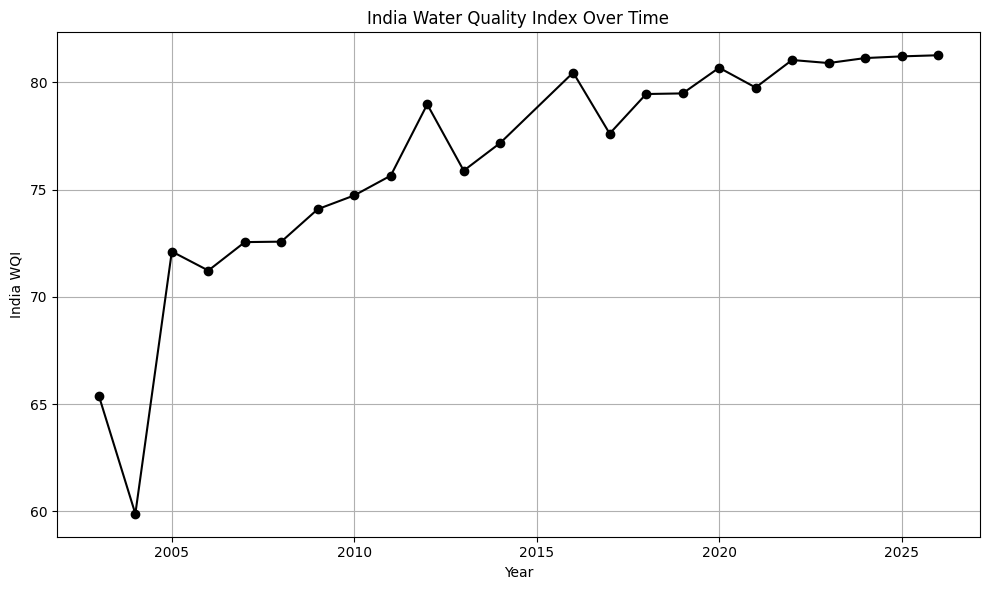

In [46]:
# prediction of wqi for India

cols = ['year', 'wqi']

aggregated_data = data[cols].groupby('year').mean()
years = aggregated_data.index.tolist()
np_year_list = np.array(years)
old_wqi = np.array(aggregated_data['wqi'])
combined_array = np.stack((old_wqi, np_year_list), axis=1)
model = predictParameterModel(combined_array)
predicted_india_wqi = []
for year in YEAR_LIST:
    predicted_india_wqi.append(model(year))
predicted_india_wqi = [81.03478, 80.89324, 81.125, 81.204, 81.256]
india_wqi = np.concatenate((old_wqi, np.array(predicted_india_wqi)))
# print(india_wqi)
years = np.concatenate((np_year_list, np.array(YEAR_LIST)))
# print(years)

# Plotting the line graph
plt.figure(figsize=(10, 6))
plt.plot(years, india_wqi, marker='o', linestyle='-', color='black')

# Adding labels and title
plt.xlabel('Year')
plt.ylabel('India WQI')
plt.title('India Water Quality Index Over Time')

# Show the plot
plt.grid(True)
plt.tight_layout()

plt.savefig('india_wqi_year.png')

plt.show()


In [47]:
def store_in_file(state_name, prediction_list):
    file_name = f"{state_name}_prediction.csv"
    file_path = os.path.join('prediction/', file_name)
    with open(file_path, 'w') as file:
        year_in_string = [str(num) for num in YEAR_LIST]
        prediction_in_string = [str(num) for num in prediction_list]
        file.write(','.join(year_in_string) + '\n')
        file.write(','.join(prediction_in_string) + '\n')

In [48]:
# Predicting the WQI for each state

for state_name in STATE_NAME_LIST:
    if state_name == 'DAMAN AND DIU' or state_name == 'DADRA AND NAGAR HAVELI' or state_name == 'INTER-STATE':
        continue
    wqi_prediction = []
    aggregated_data = data[data['state'] == state_name][numeric_cols].groupby('year').mean()
    ag = aggregated_data
    old_wqi = ag['wqi'].tolist()
    year_list = aggregated_data.index.tolist()
    year_each_state[state_name] = year_list
    if(len(year_list) == 1 or len(year_list) == 0):
        continue
    np_year_list = np.array(year_list)
    import warnings
    warnings.filterwarnings("ignore", category=np.RankWarning)
    models_for_params = {}
    for parameter in parameter_list:
        values = np.array(ag[parameter].tolist())
        combined_array = np.stack((values, np_year_list), axis=1)
        model = predictParameterModel(combined_array)
        models_for_params[parameter] = model
    predicted_values = {}
    for year in YEAR_LIST:
        for parameter in parameter_list:
            predicted_value = models_for_params[parameter](year)
            # print(predicted_value, type(predicted_value))
            if np.isnan(predicted_value):
                # print("nan: ", state_name)
                predicted_value = mean[parameter]
            predicted_values[parameter] = predicted_value
        wqi = predicted_values['wph']+predicted_values['wdo']+predicted_values['wbdo']+predicted_values['wec']+predicted_values['wna']+predicted_values['wco']
        if year == 2022:
            file_path = os.path.join('prediction/', 'all_states_2022.csv')
            with open(file_path, 'a') as file:
                # print(state_name, wqi, predicted_values['tc'], predicted_values['ph'], predicted_values['do'], predicted_values['bod'])
                file.write(state_name + ',' + str(wqi) + ',' + str(predicted_values['tc']) + ',' + str(predicted_values['ph']) + ',' + str(predicted_values['do']) + ',' + str(predicted_values['bod']) + '\n')

        wqi_prediction.append(abs(wqi))
    store_in_file(state_name, wqi_prediction)
    total_wqi = old_wqi + wqi_prediction
    predictions[state_name] = total_wqi

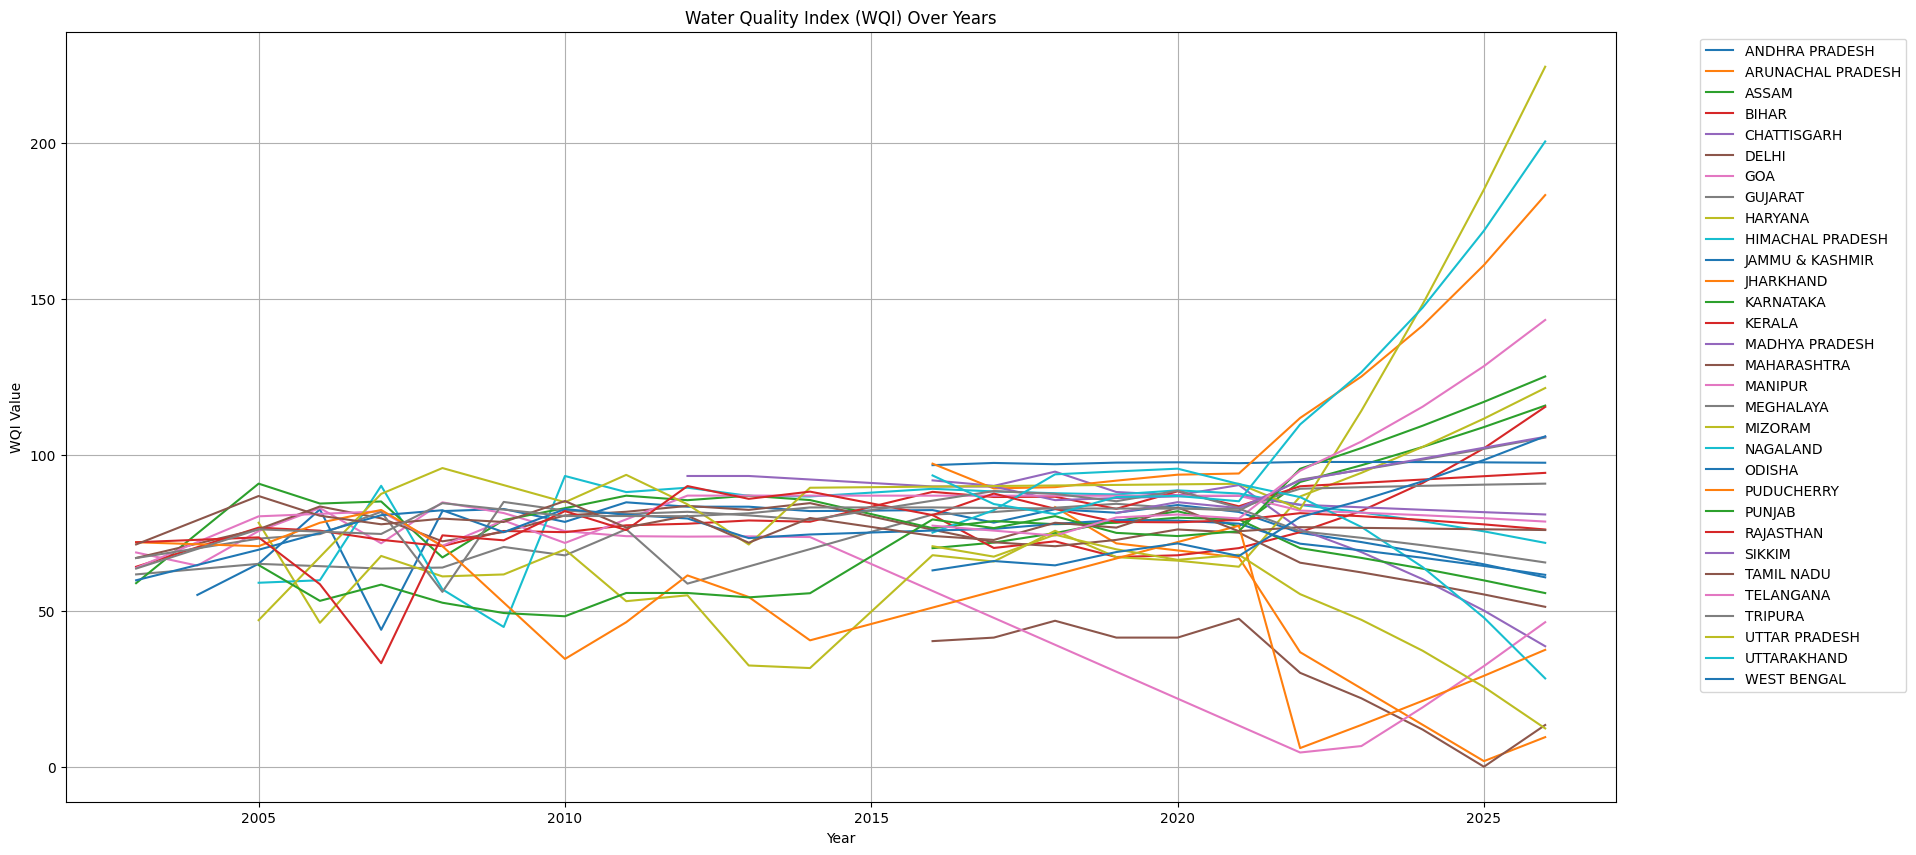

In [49]:
# Plotting the WQI for all the states in one plot
plt.figure(figsize=(20, 10))

for state, wqi_values in predictions.items():
    years = year_each_state[state] + YEAR_LIST
    plt.plot(years, wqi_values, label=state)

plt.title('Water Quality Index (WQI) Over Years')
plt.xlabel('Year')
plt.ylabel('WQI Value')

# Adjust the legend position
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')  # Adjust the coordinates as needed

plt.grid(True)
plt.savefig(f'prediction_all_states.png', bbox_inches='tight')  # Adjust bbox_inches to prevent clipping
plt.show()

plt.close()


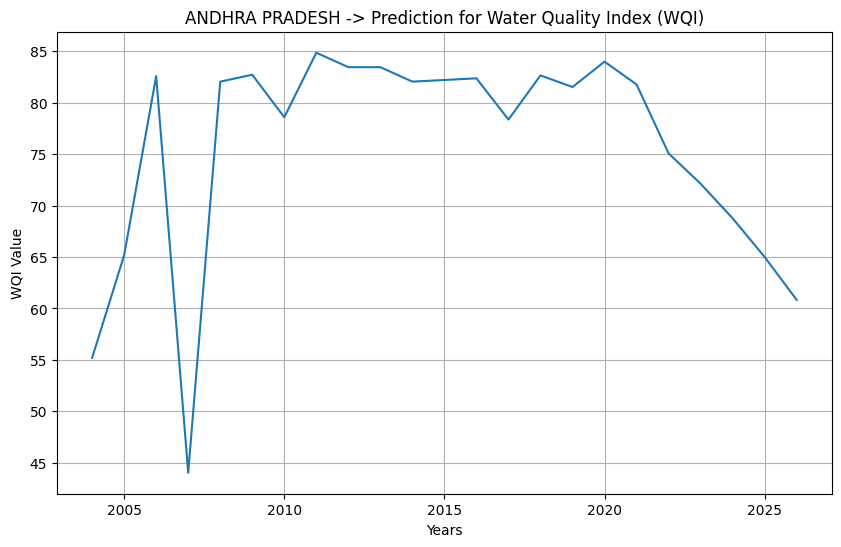

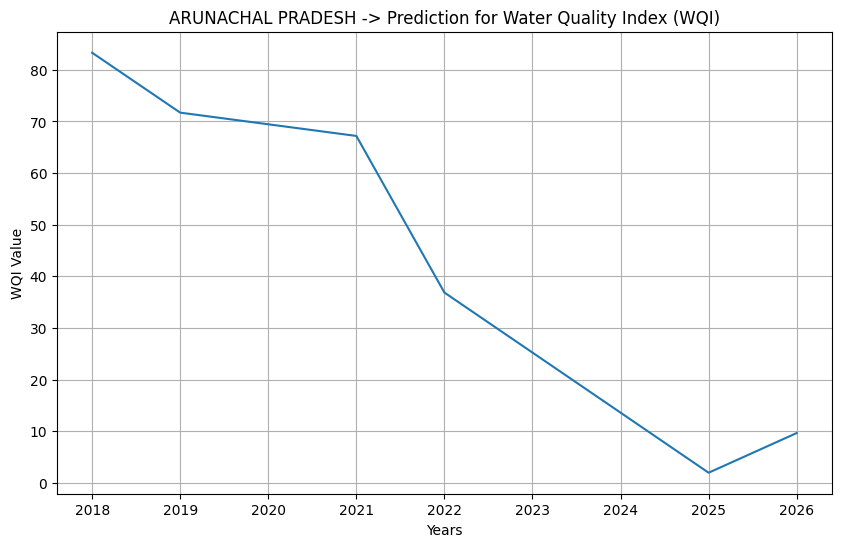

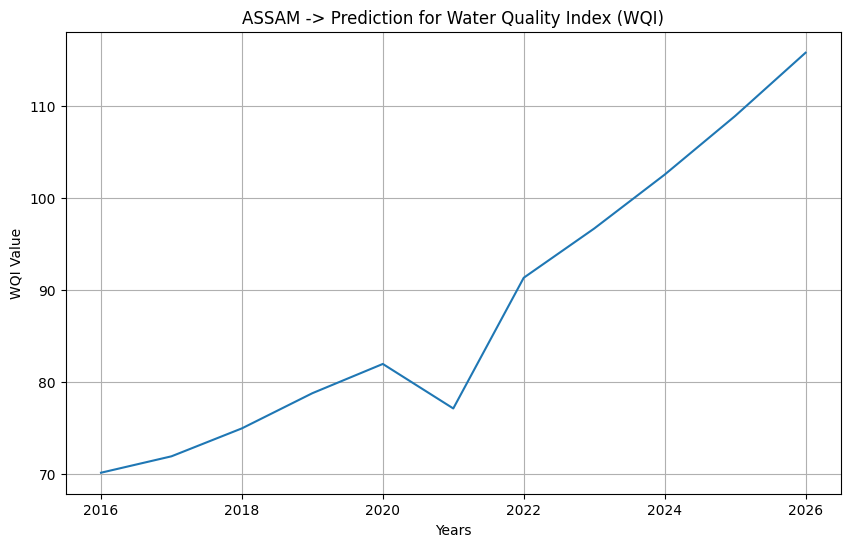

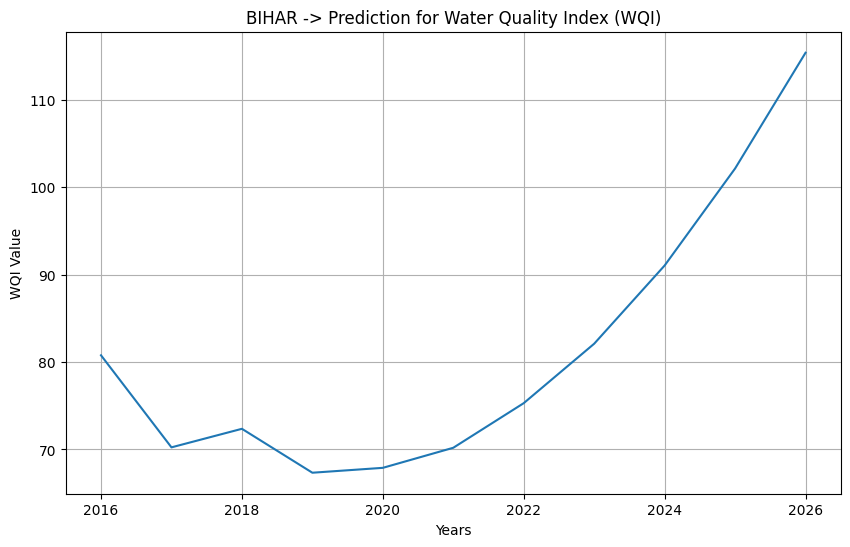

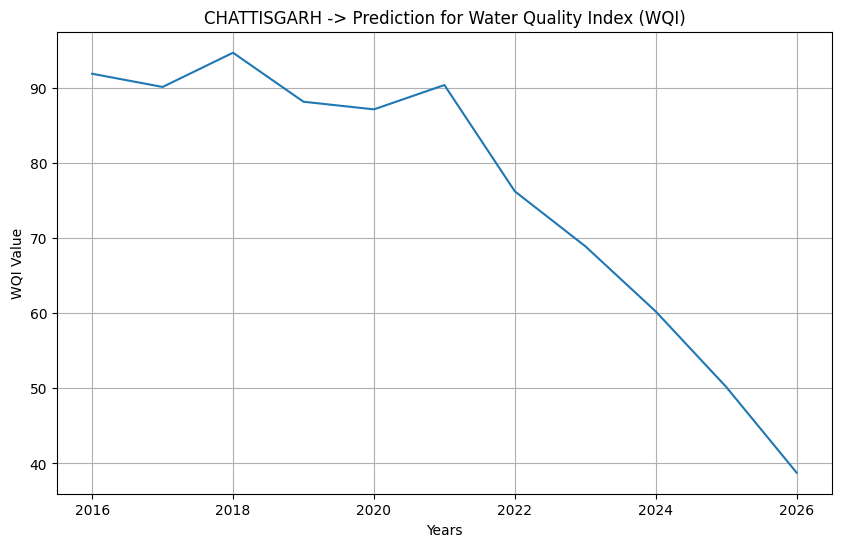

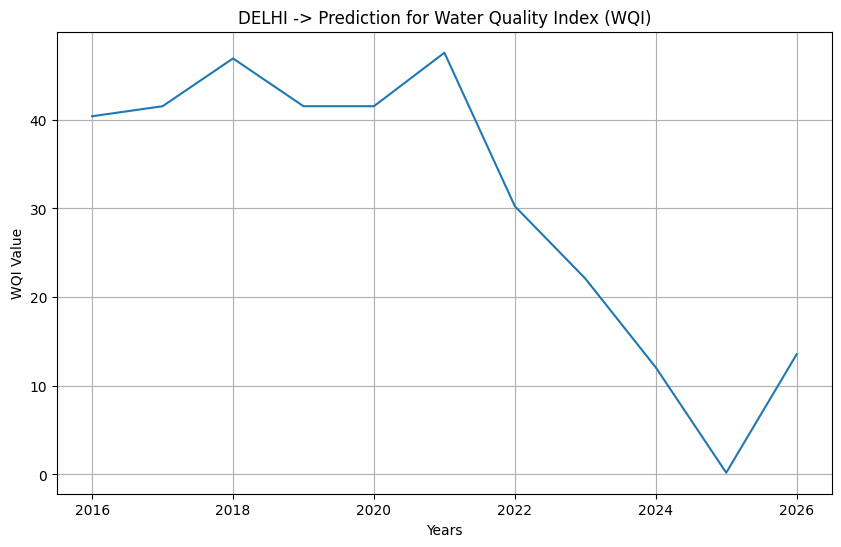

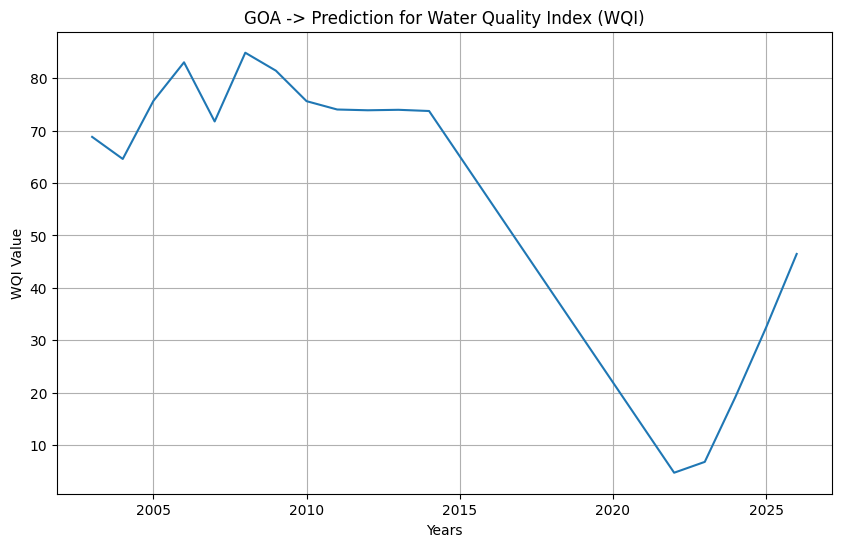

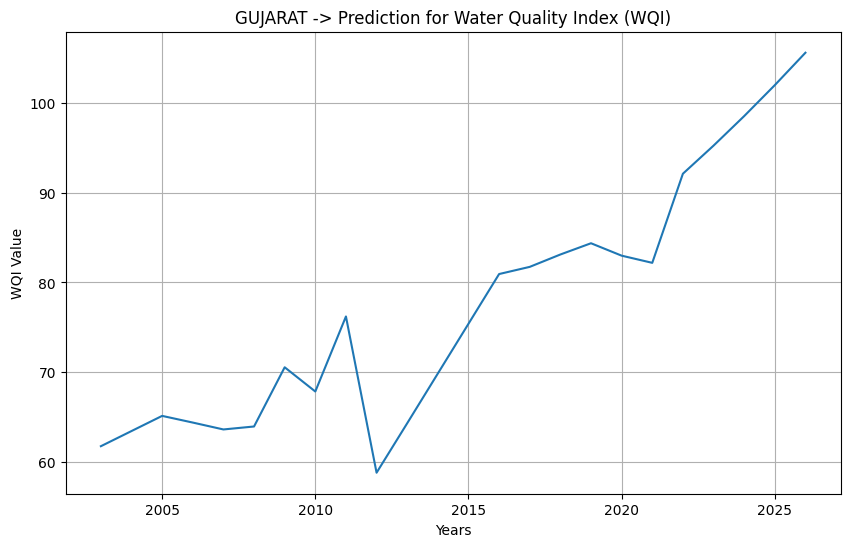

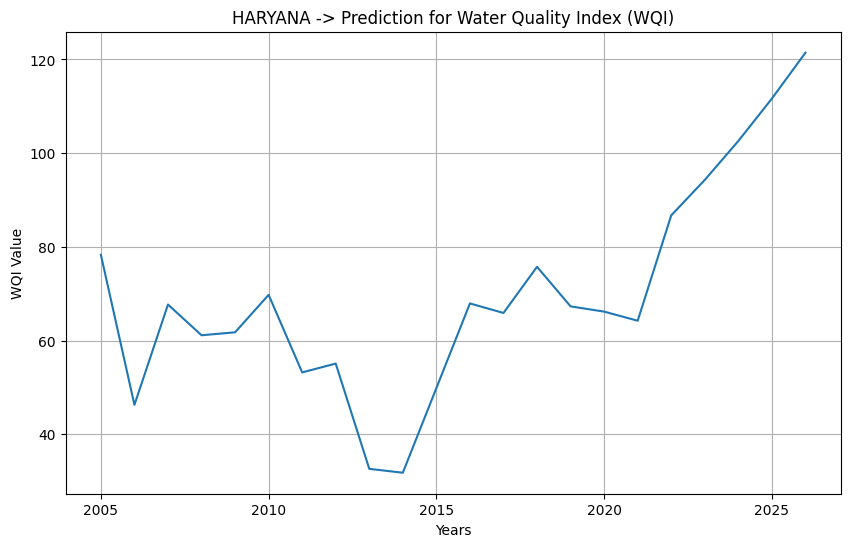

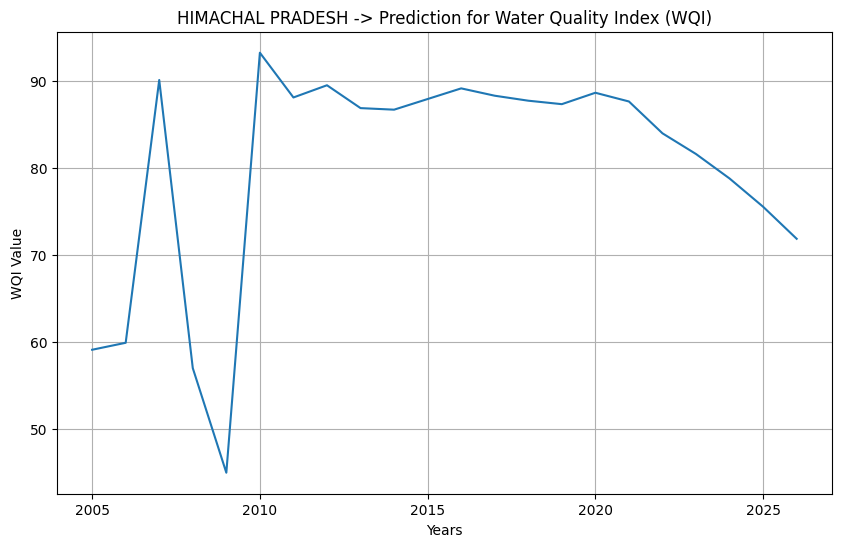

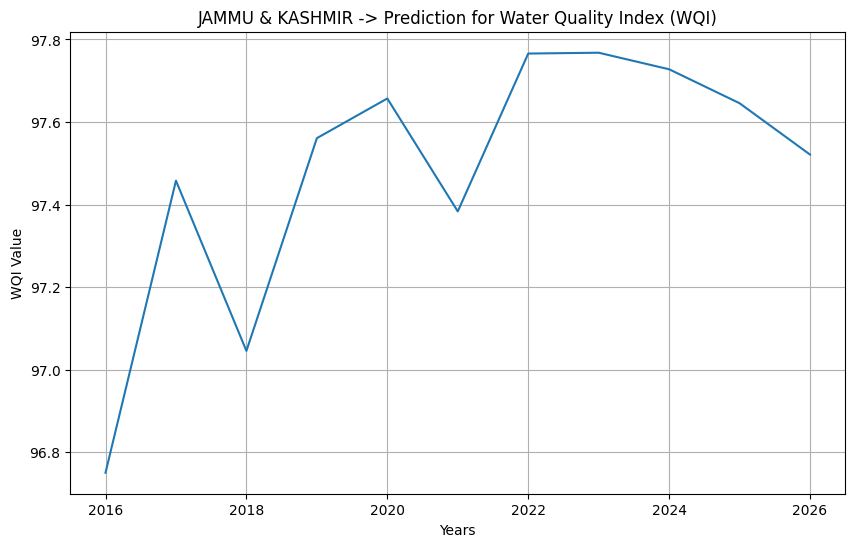

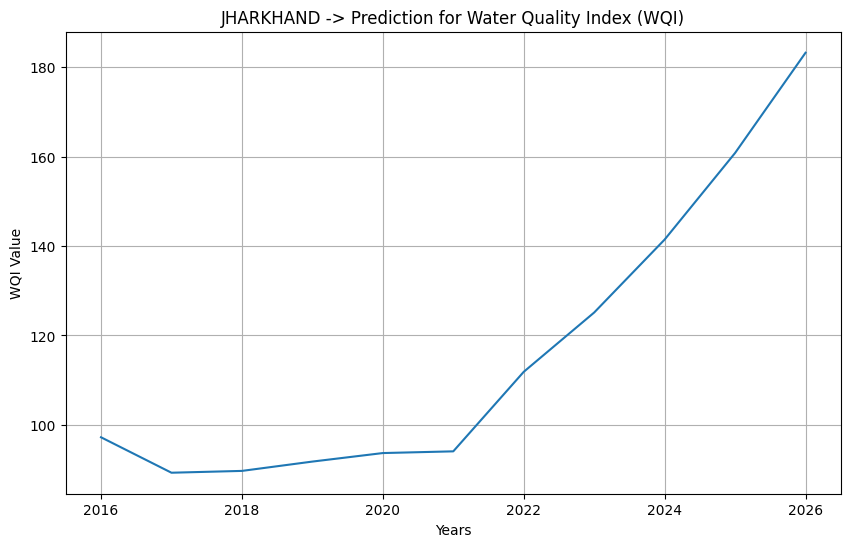

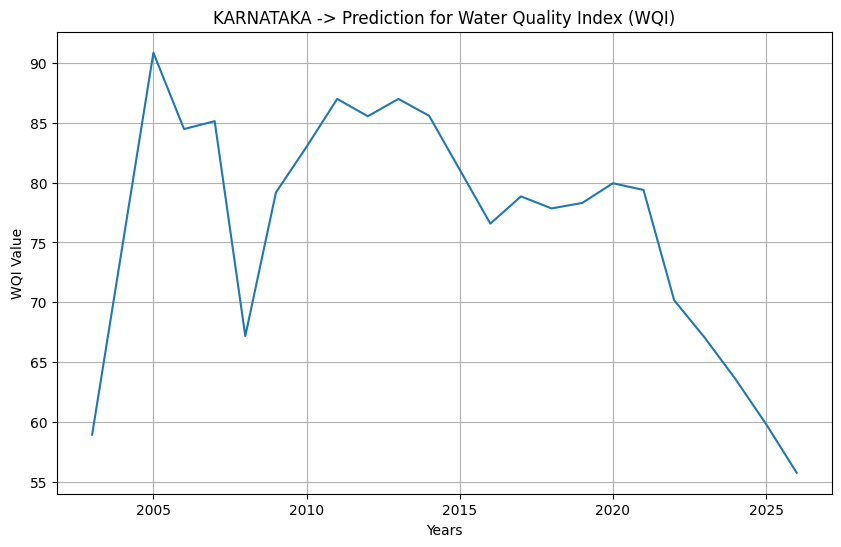

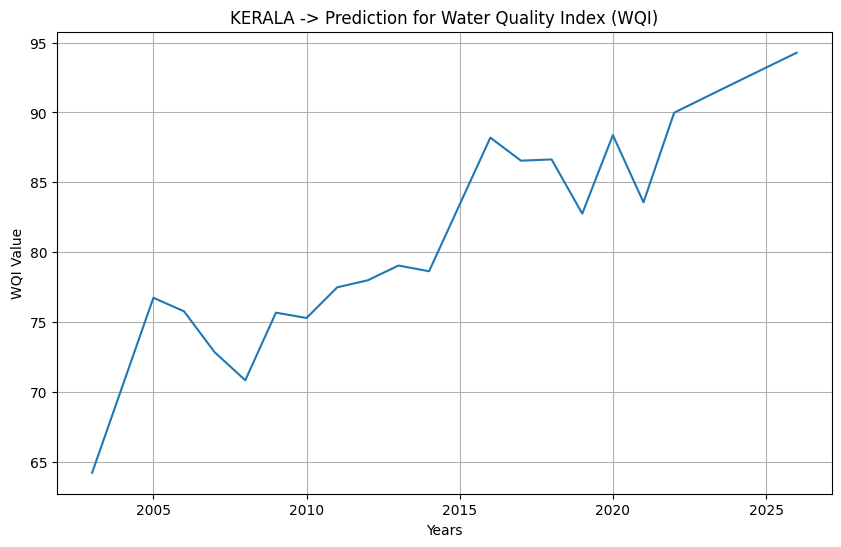

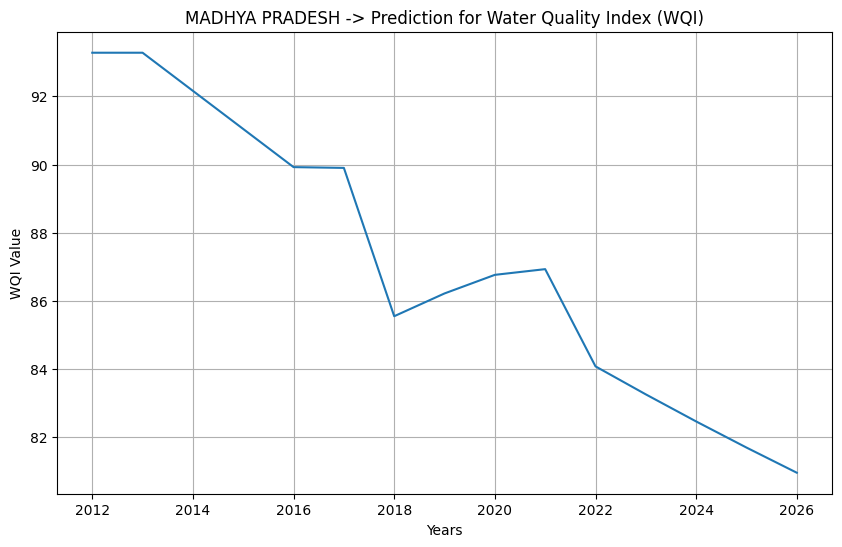

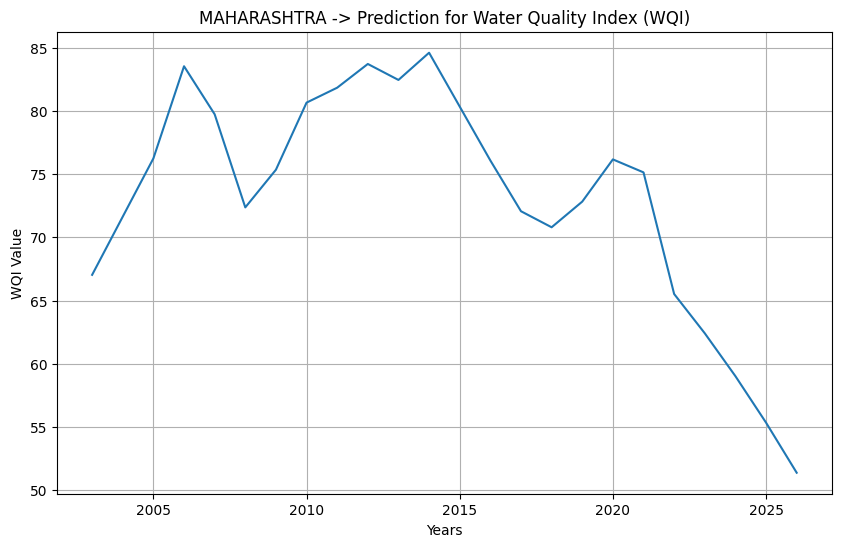

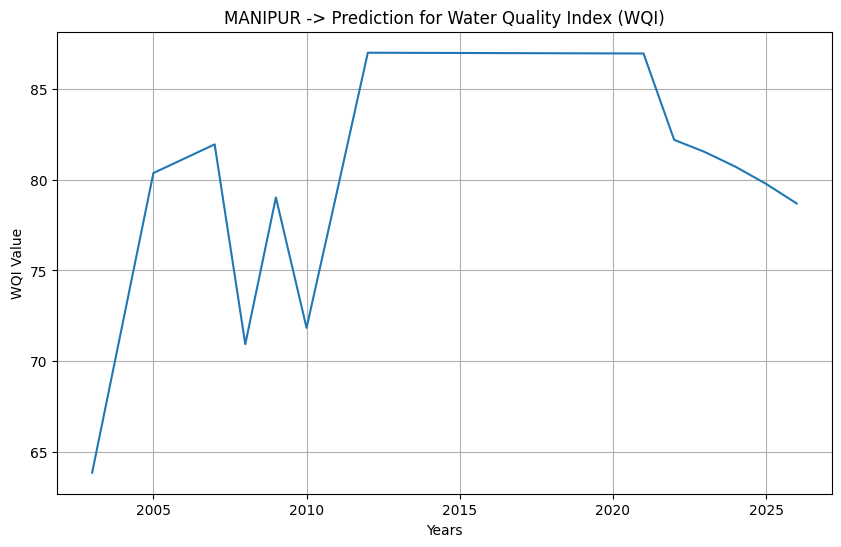

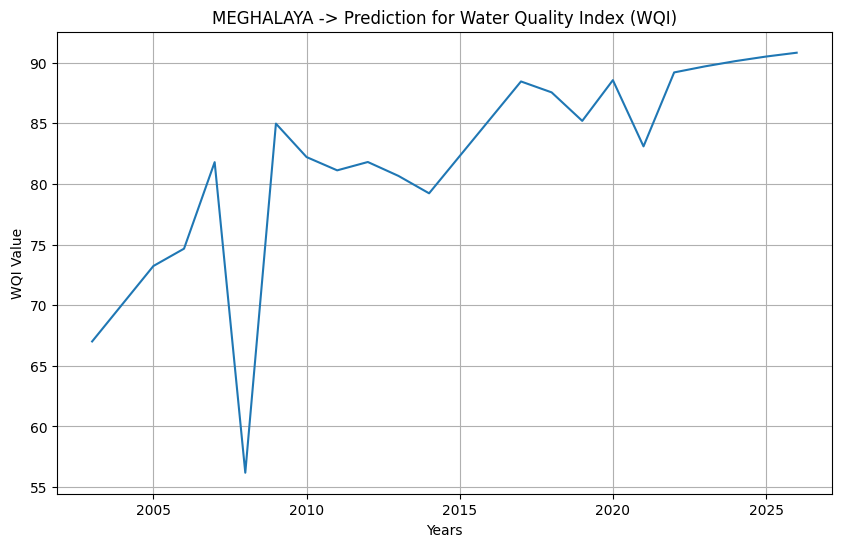

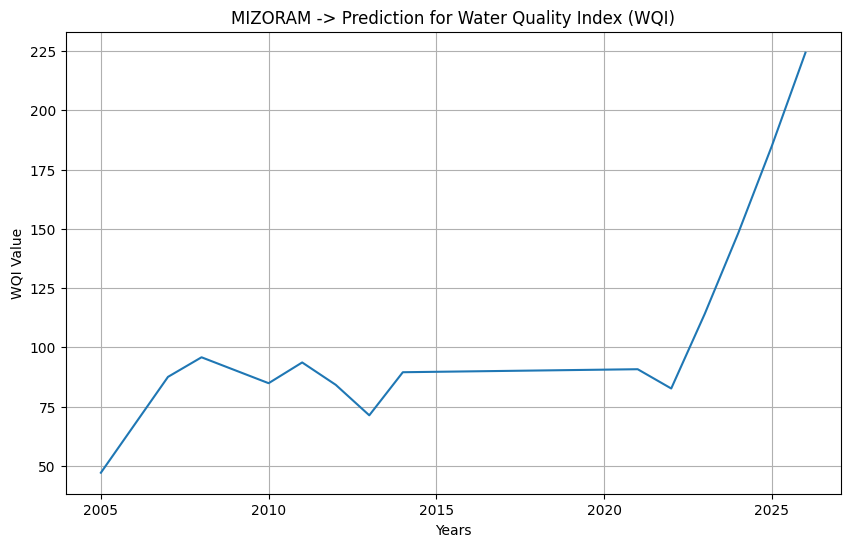

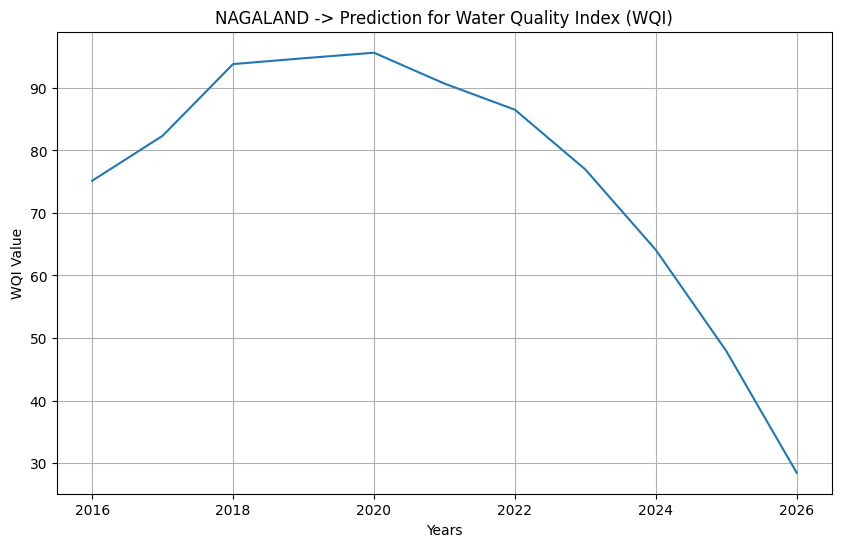

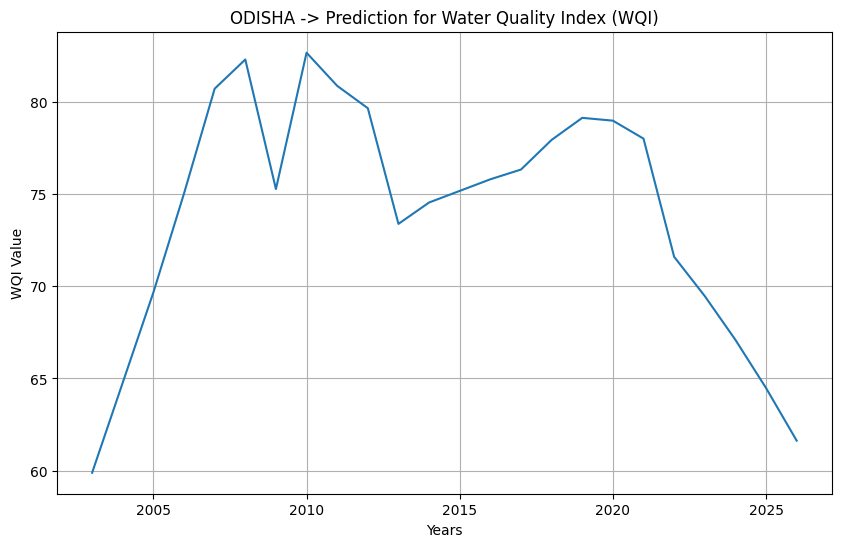

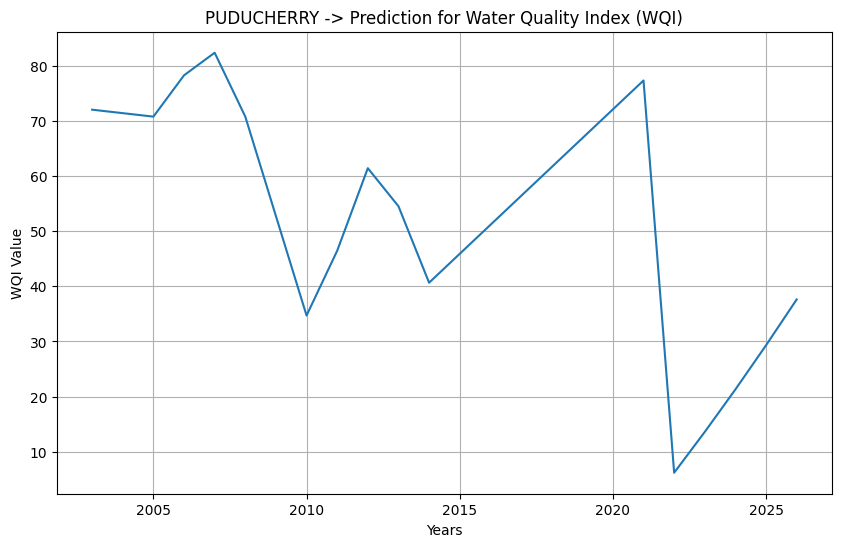

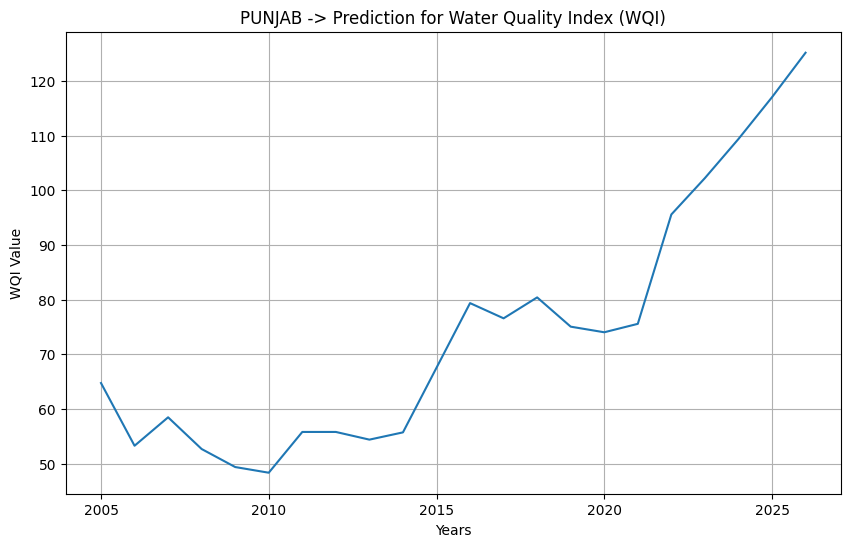

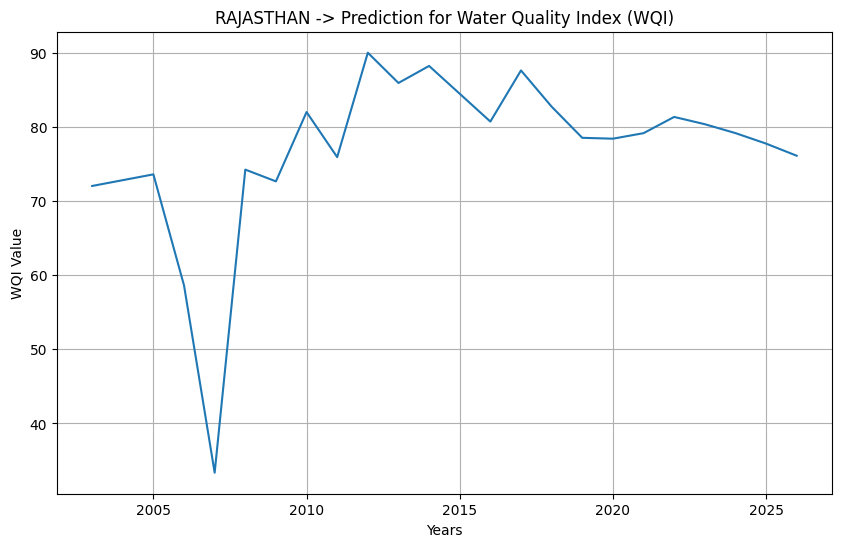

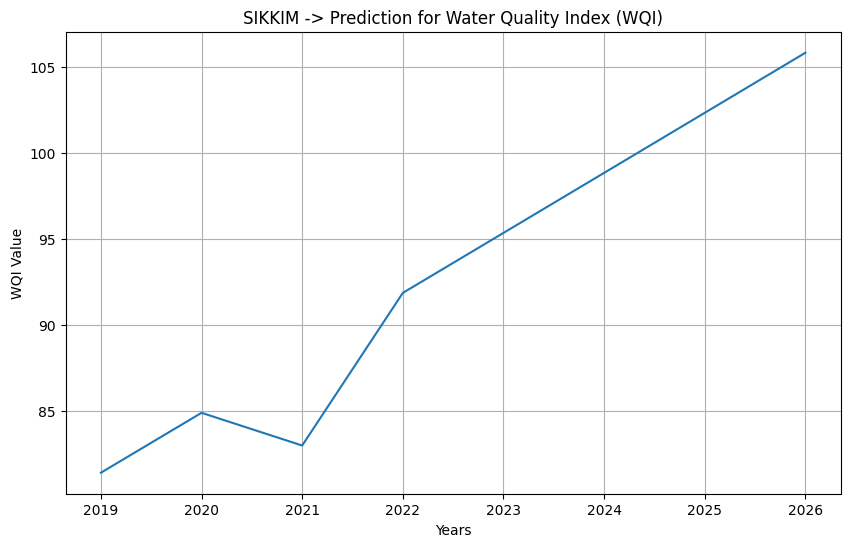

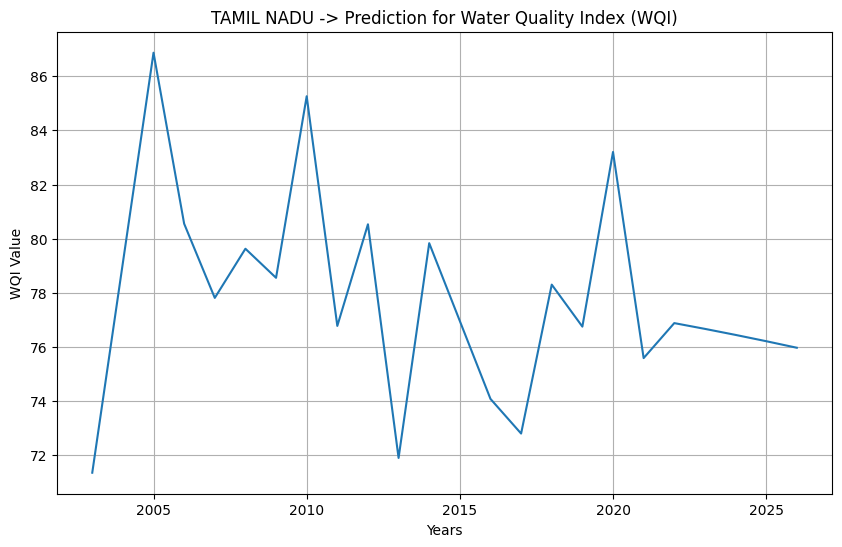

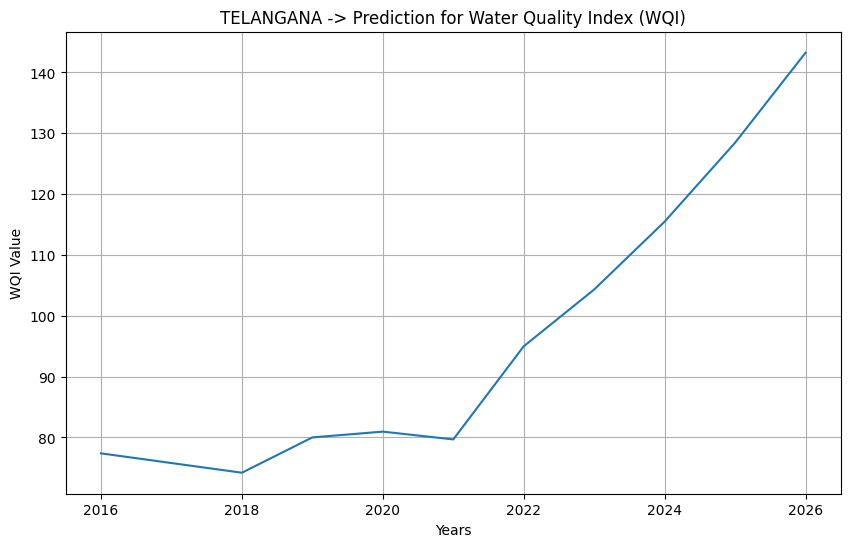

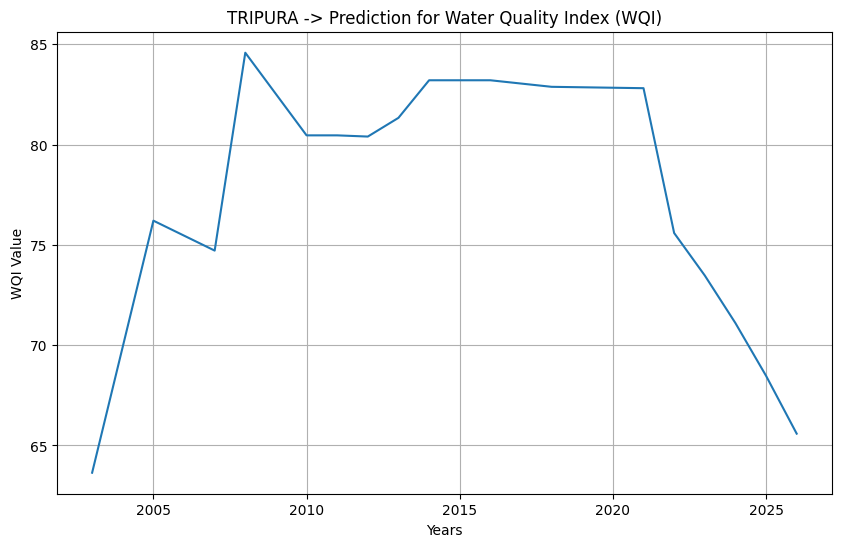

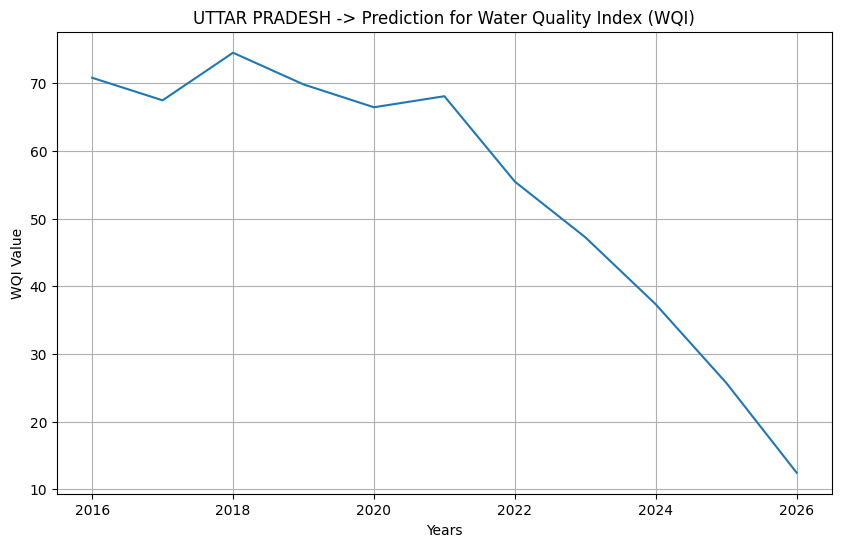

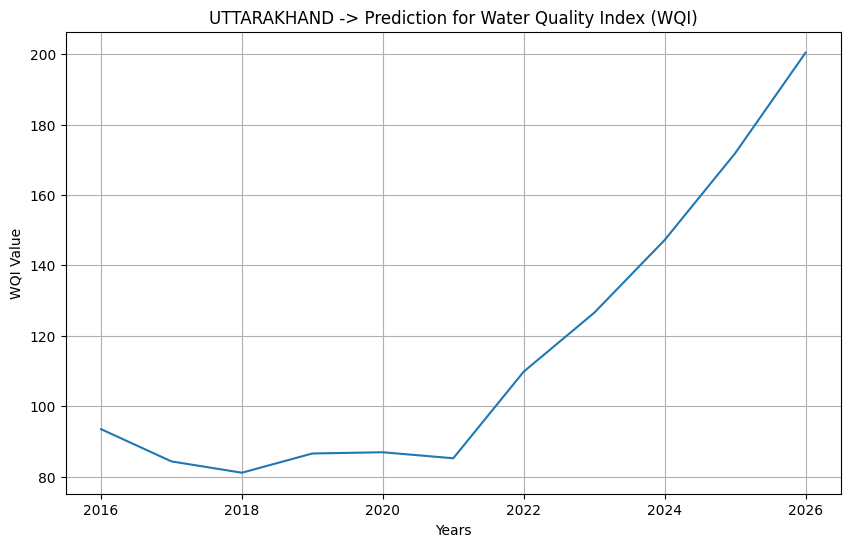

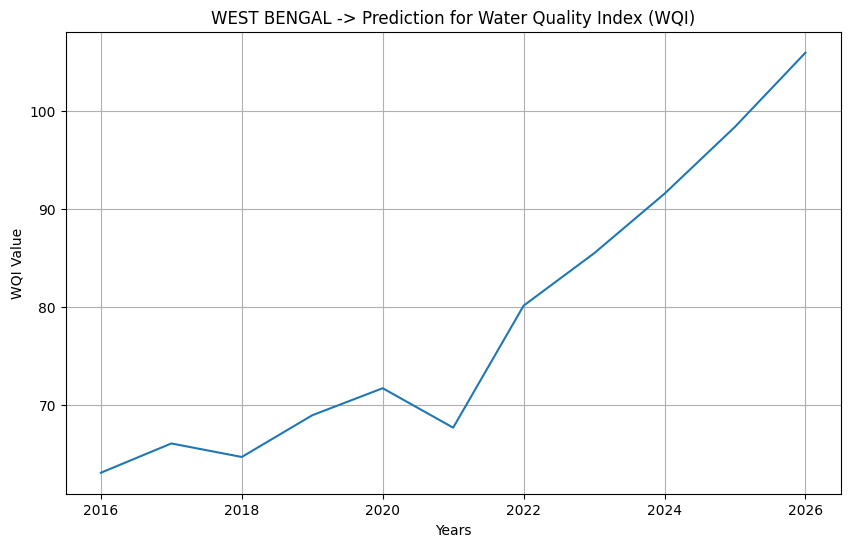

In [50]:
# Plotting wqi for each state

wqi_map = predictions

# Plotting
create_folder('images')
save_path = 'images/'

for state, wqi_values in wqi_map.items():
    wqi_values = wqi_map[state]
    plt.figure(figsize=(10, 6))
    plt.plot(year_each_state[state]+YEAR_LIST, wqi_values)
    plt.title(f'{state} -> Prediction for Water Quality Index (WQI)')
    plt.xlabel('Years')
    plt.ylabel('WQI Value')
    plt.grid(True)
    plt.savefig(os.path.join(save_path, f'{state}_WQI_Prediction.png'))
    plt.show()


    # Close the current figure to avoid overlapping plots in the next iteration
    plt.close()

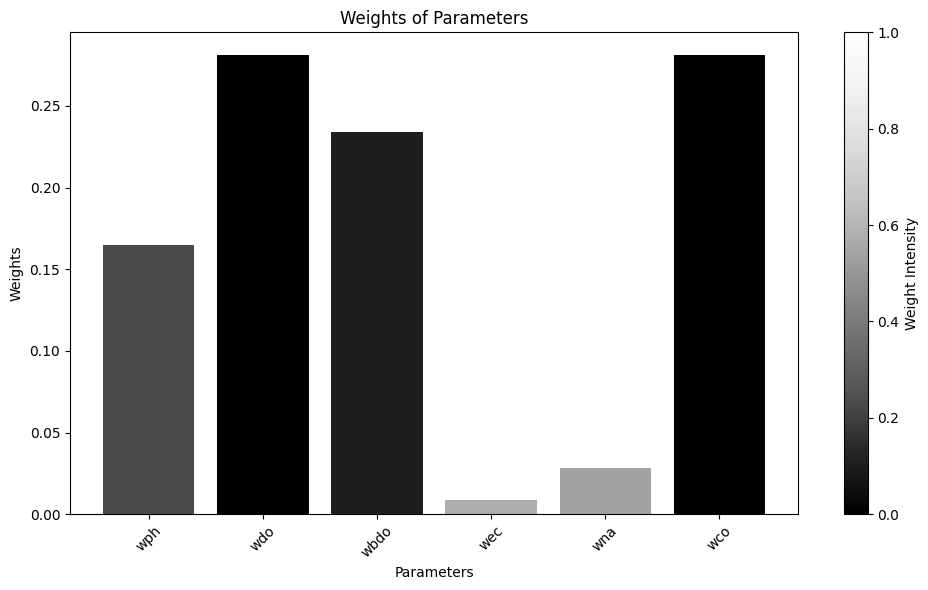

In [51]:
import matplotlib.pyplot as plt
import numpy as np

# Use the default style
plt.style.use('default')

# Define parameters and their corresponding weights
params = ['wph', 'wdo', 'wbdo', 'wec', 'wna', 'wco']
weights = [0.165, 0.281, 0.234, 0.009, 0.028, 0.281]

# Normalize weights to range [0, 1] for color mapping
weights_normalized = np.array(weights) / max(weights)

# Calculate the base grey color
base_color = 0.3

# Define colors based on shades of grey with a minimum intensity
colors = [(1 - max(weight * (1 - base_color) + base_color, base_color),) * 3 for weight in weights_normalized]

# Create bar graph
plt.figure(figsize=(10, 6))
bars = plt.bar(params, weights, color=colors)

# Add labels and title
plt.xlabel('Parameters')
plt.ylabel('Weights')
plt.title('Weights of Parameters')

# Create an empty Axes object
ax = plt.gca()

# Customize color bar
sm = plt.cm.ScalarMappable(cmap='Greys_r', norm=plt.Normalize(vmin=0, vmax=1))
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label('Weight Intensity')

# Show plot
plt.xticks(rotation=45)
plt.tight_layout()

plt.savefig('parameter_weightage.png')

plt.show()
